In [ ]:
#!pip install pycaret

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
from pycaret.classification import setup,compare_models,create_model, tune_model, evaluate_model, predict_model, finalize_model, save_model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
import os

In [ ]:
os.chdir( "/content/drive/My Drive/PES_MTech_inperson/S3_S4")

### Load the dataset from the disk

In [ ]:
import pandas as pd
df = pd.read_csv('complaints.csv') # We are taking less rows for faster execution
df.head()

,Consumer complaint narrative,Product
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


In [ ]:
df.shape

(179776, 2)

In [ ]:
df['Product'].value_counts()

,count
Product,
Debt collection,43946
Mortgage,34576
Credit reporting,31589
Credit card,18845
Bank account or service,14892
Student loan,12047
Consumer Loan,9486
"Credit reporting, credit repair services, or other personal consumer reports",6118
Payday loan,1750


<Axes: xlabel='Product'>

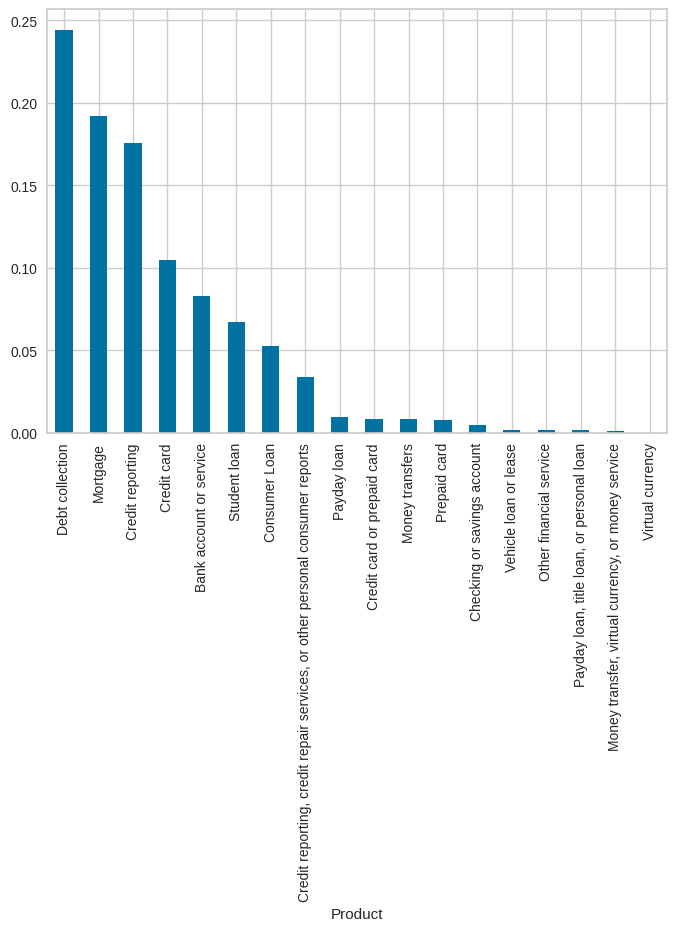

In [ ]:
df['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
stratify_column = 'Product'

In [ ]:
df_prod, _=train_test_split(df, test_size=0.75, stratify=df[stratify_column], random_state=42)

In [ ]:
df.shape

(179776, 2)

In [ ]:
df_prod.shape

(44944, 2)

<Axes: xlabel='Product'>

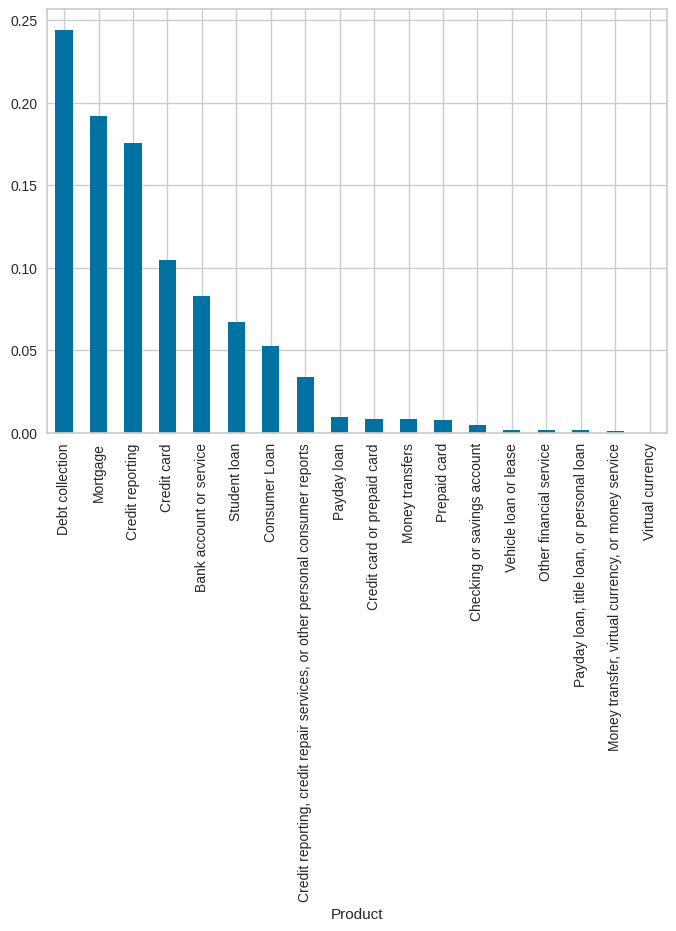

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
threshold=0.05

In [ ]:
values_below_threshold = df_prod['Product'].value_counts(normalize=True)
values_below_threshold = values_below_threshold[df_prod['Product'].value_counts(normalize=True) <=threshold ].index.tolist()

In [ ]:
values_below_threshold

['Credit reporting, credit repair services, or other personal consumer reports',
 'Payday loan',
 'Credit card or prepaid card',
 'Money transfers',
 'Prepaid card',
 'Checking or savings account',
 'Vehicle loan or lease',
 'Other financial service',
 'Payday loan, title loan, or personal loan',
 'Money transfer, virtual currency, or money service',
 'Virtual currency']

In [ ]:
len(values_below_threshold)

11

In [ ]:
df_prod['Product'] = df_prod['Product'].apply(lambda x: 'Other' if x in values_below_threshold else x)

<Axes: xlabel='Product'>

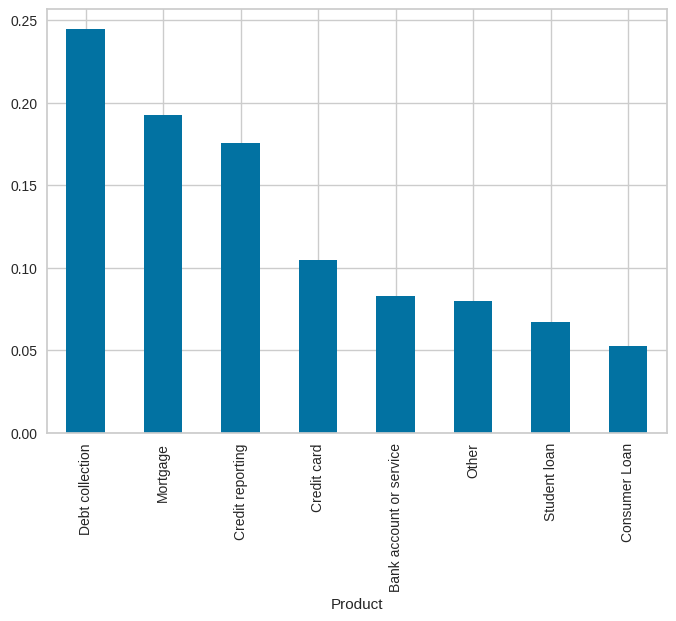

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
df_prod.isnull().sum()

,0
Consumer complaint narrative,0
Product,0


### Tokenizer
Regular expression based tokenizers to consider only alphabetical sequences and ignore numerical sequences.

In [ ]:
def cleanup(text):

    #words = comp.lower().split()
    alphabets_only = re.sub("[^a-zA-Z\s]", "", text) # Remove non-alphabetic characters
    alphabets_only = re.sub("\d+", "", alphabets_only)  # Remove digits explicitly
    alphabets_only = re.sub("\s+", " ", alphabets_only).strip() # Remove extra spaces
    return alphabets_only.lower()

In [ ]:
df_prod['Consumer complaint narrative']=df_prod['Consumer complaint narrative'].apply(cleanup)

### Vocabulary
Extracing all the unique words from the dataset

In [ ]:
def complaint_to_words(text) -> list:
    return text.split()

In [ ]:
all_words = list()
for comp in df_prod['Consumer complaint narrative']:
    for w in complaint_to_words(comp):
        all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 47743


In [ ]:
print('Complaint\n', df_prod['Consumer complaint narrative'].iloc[10], '\n')
print('Tokens\n', complaint_to_words(df_prod['Consumer complaint narrative'].iloc[10]))

Complaint
 my credit has been in consumer affairs department with equifax since they claim they protecting my identity but this not only effecting me but it is effecting my family i cant purchase a home because there are accounts on my credit from identity theft i have proof of the accounts previous being deleted also it is effecting me with irs because they have businesses reporting income that i have no clue who they are from and it is spilling over from my credit to irs 

Tokens
 ['my', 'credit', 'has', 'been', 'in', 'consumer', 'affairs', 'department', 'with', 'equifax', 'since', 'they', 'claim', 'they', 'protecting', 'my', 'identity', 'but', 'this', 'not', 'only', 'effecting', 'me', 'but', 'it', 'is', 'effecting', 'my', 'family', 'i', 'cant', 'purchase', 'a', 'home', 'because', 'there', 'are', 'accounts', 'on', 'my', 'credit', 'from', 'identity', 'theft', 'i', 'have', 'proof', 'of', 'the', 'accounts', 'previous', 'being', 'deleted', 'also', 'it', 'is', 'effecting', 'me', 'with', '

Conventional ML models with TF_IDF vectorization

In [ ]:
df_prod.sample(10)

,Consumer complaint narrative,Product
8658,we have a loan with a company called lendmark ...,Consumer Loan
112683,experian sent me a letter in response to my ce...,Credit reporting
32389,about years ago i received a notice from xxxx ...,Debt collection
138933,as a small business checking account regions b...,Bank account or service
107547,i sold my home on xxxx xxxx on a short sale i ...,Mortgage
62310,credit bureaus reported i had a zero balance o...,Other
148722,to whom it may concern as the foreclosure trus...,Mortgage
105431,phoned work number at xxxx and at xxxx xxxxxxx...,Debt collection
131949,i applied for a loan through castle payday for...,Other
164587,i received notice from a third party agency th...,Debt collection


In [ ]:
df_train=df_prod.sample(frac=0.9,random_state=50)
df_test=df_prod.drop(df_train.index)

In [ ]:
embeddings_index = {}
f = open('glove6B300d.txt') # 100, 500
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embeddings_index['complain']

array([ 3.2527e-02,  2.2988e-01, -1.9557e-02,  3.3278e-02, -5.2951e-02,
       -5.6489e-01,  5.1069e-01,  5.7265e-01, -2.9751e-02, -4.8147e-01,
       -3.5344e-01, -3.1598e-01,  3.2088e-02,  1.0543e-01,  3.9710e-01,
       -8.7283e-02,  1.3071e-01,  1.9548e-01,  3.9977e-01,  1.0762e-01,
        2.3900e-01,  1.8917e-01,  3.3207e-01, -4.7304e-01, -8.7115e-01,
       -1.7548e-01,  6.4719e-01, -5.0578e-02,  1.5748e-01,  9.9758e-02,
       -9.1057e-02,  9.1843e-02, -3.8819e-01,  1.3804e-01, -6.1406e-01,
       -3.1280e-01, -4.5383e-01, -5.2764e-01,  1.2899e-01, -2.4697e-01,
       -1.3493e-01, -8.2438e-02,  1.8350e-01, -2.2309e-01, -6.8667e-02,
       -7.1235e-02, -2.6234e-01, -3.9099e-01, -2.3084e-01,  1.7475e-02,
        6.9834e-01, -1.4596e-01,  8.8063e-02, -1.1095e-01, -1.5102e-01,
        5.5594e-01,  5.5126e-02,  4.9870e-02,  1.5364e-01,  5.4854e-01,
       -3.9070e-03, -3.6060e-01, -2.2152e-01,  3.1040e-02, -4.0910e-01,
       -2.4344e-01,  3.6464e-01, -1.1284e-02,  2.2683e-01, -3.36

In [ ]:
embeddings_index['card']

array([ 1.9725e-01,  3.6307e-01, -6.5363e-03, -1.3093e-01,  9.7881e-02,
        1.0672e-01, -1.5430e-01, -3.1742e-02, -5.1712e-02, -9.3833e-01,
        4.1408e-01,  2.0887e-01,  6.3699e-01, -6.3321e-01, -1.7270e-01,
       -2.2408e-01,  2.0129e-01, -4.3269e-01, -2.5507e-01, -1.3045e-01,
        4.4514e-01, -5.9279e-01, -6.2765e-01, -4.1515e-01,  4.0791e-01,
       -6.0161e-02,  1.8861e-01,  5.6771e-01,  1.6858e-01,  6.9926e-02,
       -3.1033e-01,  3.1911e-01,  2.0722e-01, -4.1818e-01, -1.8162e+00,
       -2.2084e-01,  9.0885e-02, -6.3209e-01, -7.5685e-01, -1.1297e-02,
       -1.0836e-01, -1.6254e-01,  4.3498e-01,  6.9685e-01, -1.2920e-02,
       -1.9297e-01,  4.1904e-01, -3.3157e-01, -3.3217e-01, -5.7933e-01,
        1.3879e-01,  3.6685e-01,  3.2189e-01,  1.6017e-01, -1.8093e-01,
       -7.9015e-01, -5.2711e-01,  1.2996e-01,  5.3166e-02, -5.5447e-01,
        4.4743e-01, -3.9521e-03, -3.7500e-01,  1.1905e-01, -4.8357e-02,
       -1.8989e-01,  2.2412e-02, -5.8759e-01,  2.5898e-01, -3.41

In [ ]:
embeddings_index['bank']

array([-2.1905e-01, -4.9229e-01, -2.9832e-01, -1.5174e-01,  7.2112e-01,
       -4.0707e-01,  2.0795e-01,  7.2568e-02, -5.4285e-01, -1.9575e+00,
       -3.7190e-01, -1.4800e-01,  6.9628e-01, -1.6200e-01,  4.1163e-01,
       -3.2974e-01, -1.7257e-01, -9.5980e-01, -1.9443e-02, -2.4287e-01,
        1.8278e-01, -2.1504e-01,  5.5201e-01, -4.2965e-01, -1.1847e-02,
       -2.9445e-01, -9.6791e-02,  1.9609e-02, -6.3745e-01,  1.3596e-01,
       -4.6089e-01,  5.4057e-02,  4.3705e-01,  6.0848e-01, -3.8690e-01,
       -4.1995e-01,  2.9857e-01,  2.1955e-01, -3.0450e-01, -1.5579e-01,
       -5.3451e-01, -2.8770e-02, -2.4630e-01,  5.0938e-01,  3.5705e-01,
        1.5714e-01, -4.4538e-01, -1.0509e-01, -5.1263e-01,  4.1623e-01,
       -2.9497e-01,  1.3533e-01,  5.9177e-01,  6.6543e-02, -1.1167e-01,
        2.5370e-01,  1.5957e-01,  3.3437e-02, -8.1858e-02, -4.4272e-01,
        1.3396e-01, -2.3204e-02, -1.8991e-01, -3.8790e-01,  2.7375e-01,
        1.6475e-01,  7.2086e-01, -1.4851e-01, -8.7379e-02, -2.84

#### Taking average of all word embeddings in a sentence to generate the sentence representation.

In [ ]:
def encode_text(text, embedding_dict, embedding_dim=300):
    words = text.split()
    word_vectors = [embedding_dict[word] for word in words if word in embedding_dict]

    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)  # Return a zero vector if no word is found

    return np.mean(word_vectors, axis=0)

In [ ]:
df_prod['Glove_Encoding'] = df_prod['Consumer complaint narrative'].apply(lambda x: encode_text(x, embeddings_index))

In [ ]:
encoded_df = pd.DataFrame(df_prod['Glove_Encoding'].tolist(), index=df_prod.index)
encoded_df['Product'] = df_prod['Product'].values

In [ ]:
encoded_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Product
173031,-0.079408,-0.007782,-0.083602,-0.100322,-0.040740,-0.024558,0.013657,-0.052081,-0.002555,-1.375652,...,-0.145181,0.043872,-0.049471,0.241021,0.049103,0.152256,-0.189287,-0.137939,0.045260,Mortgage
54347,-0.048562,0.007169,-0.088462,-0.145011,0.106417,0.097964,-0.069078,0.002550,0.055333,-1.291430,...,-0.133779,0.100427,0.162654,0.172940,0.095855,0.156237,-0.178956,-0.011222,-0.011932,Other
82527,-0.089667,-0.097477,-0.069934,-0.162727,0.074795,0.035682,-0.080131,0.078376,-0.014536,-1.459902,...,-0.122305,-0.002090,-0.009939,0.172275,0.119741,-0.033421,-0.092770,-0.103871,-0.106981,Bank account or service
55692,-0.105308,0.143432,-0.098871,-0.096032,-0.058626,-0.024487,-0.010470,-0.074515,0.008697,-1.681539,...,-0.163993,0.080514,0.003887,0.151499,0.036311,0.100845,-0.229835,-0.082987,0.058468,Credit reporting
65160,-0.090365,0.027101,-0.077297,-0.135046,-0.025600,0.047960,0.010730,-0.054362,-0.024419,-1.391538,...,-0.163903,0.050420,0.021431,0.184894,0.044909,0.098253,-0.176933,-0.060292,-0.000091,Mortgage
34282,-0.121796,0.077248,-0.066308,-0.122001,-0.049073,-0.008613,-0.026918,-0.021571,0.043062,-1.577268,...,-0.204874,0.026588,0.010566,0.205257,0.082599,0.051313,-0.171281,-0.115005,0.010687,Mortgage
136255,-0.195642,0.099346,-0.068535,-0.090236,-0.009672,-0.084934,-0.025805,-0.113407,0.063093,-1.521803,...,-0.157356,0.046280,-0.019884,0.172285,-0.078068,0.076376,-0.144677,-0.055711,0.121410,Debt collection
6083,-0.108837,0.039374,-0.079916,-0.080459,0.012886,0.000249,-0.031238,-0.070596,0.017121,-1.508918,...,-0.137090,0.045231,0.012979,0.201885,-0.012880,0.125833,-0.197899,-0.068671,0.089933,Mortgage
178048,-0.120742,0.066139,-0.074688,-0.101032,0.001927,0.038048,-0.031720,0.000257,0.044555,-1.467690,...,-0.165444,0.068435,0.043755,0.133171,0.081698,0.082681,-0.226005,-0.069192,0.036975,Mortgage
16333,-0.116611,0.056982,-0.022574,-0.111028,0.037861,0.070607,-0.042510,-0.006243,0.006154,-1.392047,...,-0.174204,-0.027567,0.042240,0.143046,0.111979,0.033436,-0.139148,-0.058808,-0.018401,Bank account or service


In [ ]:
py_clas=setup(data=encoded_df,target='Product',  train_size=0.8,session_id=50)

,Description,Value
0,Session id,50
1,Target,Product
2,Target type,Multiclass
3,Target mapping,"Bank account or service: 0, Consumer Loan: 1, Credit card: 2, Credit reporting: 3, Debt collection: 4, Mortgage: 5, Other: 6, Student loan: 7"
4,Original data shape,"(44944, 301)"
5,Transformed data shape,"(44944, 301)"
6,Transformed train set shape,"(35955, 301)"
7,Transformed test set shape,"(8989, 301)"
8,Numeric features,300
9,Preprocess,True


In [ ]:
best_model= compare_models(verbose=True,   fold=5, round=3, turbo=True, exclude=['nb','lda', 'qda','ada', 'dt','gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.739,0.000,0.739,0.721,0.722,0.686,0.688,12.204
ridge,Ridge Classifier,0.726,0.000,0.726,0.720,0.696,0.668,0.672,0.666
svm,SVM - Linear Kernel,0.721,0.000,0.721,0.710,0.695,0.663,0.667,3.698
xgboost,Extreme Gradient Boosting,0.719,0.935,0.719,0.707,0.704,0.661,0.663,125.066
lightgbm,Light Gradient Boosting Machine,0.711,0.933,0.711,0.696,0.694,0.651,0.653,157.310
rf,Random Forest Classifier,0.637,0.898,0.637,0.658,0.598,0.554,0.563,57.170
et,Extra Trees Classifier,0.629,0.894,0.629,0.666,0.588,0.543,0.553,14.674
knn,K Neighbors Classifier,0.584,0.840,0.584,0.569,0.569,0.503,0.505,9.224
dummy,Dummy Classifier,0.244,0.500,0.244,0.060,0.096,0.000,0.000,0.478


Processing:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
py_clf=create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7378,0.0000,0.7378,0.7195,0.7182,0.6843,0.6866
1,0.7389,0.0000,0.7389,0.7157,0.7205,0.6861,0.6881
2,0.7408,0.0000,0.7408,0.7194,0.7221,0.6879,0.6902
3,0.7378,0.0000,0.7378,0.7193,0.7198,0.6843,0.6865
4,0.7392,0.0000,0.7392,0.7222,0.7233,0.6861,0.6880
5,0.7352,0.0000,0.7352,0.7176,0.7190,0.6809,0.6830
6,0.7410,0.0000,0.7410,0.7269,0.7270,0.6885,0.6903
7,0.7477,0.0000,0.7477,0.7306,0.7319,0.6966,0.6984
8,0.7371,0.0000,0.7371,0.7170,0.7204,0.6838,0.6857


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_clf=tune_model(py_clf, round=3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.751,0.000,0.751,0.734,0.736,0.701,0.703
1,0.749,0.000,0.749,0.730,0.735,0.699,0.700
2,0.744,0.000,0.744,0.724,0.729,0.693,0.695
3,0.745,0.000,0.745,0.727,0.731,0.693,0.695
4,0.747,0.000,0.747,0.732,0.736,0.696,0.697
5,0.744,0.000,0.744,0.729,0.732,0.692,0.694
6,0.749,0.000,0.749,0.738,0.739,0.699,0.700
7,0.751,0.000,0.751,0.737,0.740,0.702,0.703
8,0.751,0.000,0.751,0.734,0.738,0.701,0.702


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
evaluate_model(tuned_clf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…